**Computer Vision**
Juan Álvarez Fernández del Vallado



The purpose of this lab is to detect a human face using the laptop's camera. To do so,we are going to use the Cascade functions and start from the cv2 repository, available in GitHub.


The program will start by analizing all the pixels in the whole image. Once it recognizes a human face, it will square it and save it in a buffer. After a while, it will search for a new face in the surroundings of the square it detected before. This design schema was selected to improve efficiency and timing.

The code considers that you have already cloned the opencv repository. Otherwise it can't access the cascade functions and other critical modules.




# Basic imports

Firstly we need to import from github the opencv modules.

The next step will be to copy the necessary modules to our working space.

In [1]:
! git clone https://github.com/opencv/opencv
! cp /content/opencv/samples/python/common.py .
! cp /content/opencv/samples/python/video.py .
! cp /content/opencv/modules/python/test/tst_scene_render.py .

Cloning into 'opencv'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 270871 (delta 1), reused 3 (delta 1), pack-reused 270864
Receiving objects: 100% (270871/270871), 468.31 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (189065/189065), done.
Checking out files: 100% (6152/6152), done.


In [0]:

# Python 2/3 compatibility
from __future__ import print_function

import numpy as np
import cv2 
import cv2 as cv
from google.colab.patches import cv2_imshow # Needed to print out image

# OpenCv imports
from common import clock, draw_str
import video
from video import presets


import io
import base64



from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

# Debugging
import pdb

# Histogram imports
import sys
PY3 = sys.version_info[0] == 3

if PY3:
    xrange = range


# Laboratory 1



The purpose of this lab is to detect a human face using the laptop's camera. To do so,we are going to use the Cascade functions and start from cv2 repository,


The program will start by analizing all the pixels in the whole image. Once it recognizes a human face, it will square it and save it in a buffer. After a while, it will search for a new face in the surroundings of the square it detected before. This design schema was sleected to improve efficiency and timing.

The code considers that you have already cloned the opencv repository. Otherwise it can't access the cascade functions and other critical modules.




![picture](https://drive.google.com/uc?id=1JwFe2cXPcqDeKxS6195QshHyd-7SxkxC)

In [3]:
#MAIN PROGRAM. Laboratory 1

'''
face detection using haar cascades

'''

# Detection algorithm import
# Load cascade file for the detection
cascade_fn="/content/opencv/data/haarcascades/haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cv2.samples.findFile(cascade_fn))

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showing(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

# Needed to convert an image to array
def byte2image(byte):
  jpeg = base64.b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

#Inverse operation as above. Needed to show the image.
def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = base64.b64encode(buffer.read()).decode('utf-8')
  return x
  # Function which draws a rectangle in a given photo. It can also select a color and add a label
def draw_rects(img, rects, color, Label):
    cv2.putText(img, Label, (rects[0][0], rects[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

# This is the function responsible for detecting a face using the cascade classifier.
def detect(img, cascade = cascade):
    rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
    if len(rects) == 0:
        return []
    rects[:,2:] += rects[:,:2]
    return rects

#Limit margin of the detected area. Set to 50
def setMargin(im, area, margin = 50):
    area[0][0] = max(area[0][0]-margin, 0)
    area[0][1] = max(area[0][1]-margin, 0)
    area[0][2] = min(area[0][2] + margin, im.shape[1])
    area[0][3] = min(area[0][3] + margin, im.shape[0])

#Transform the points from the previously cropped area
def transformation(rects, area):
    rects[0][0] += area[0][0]
    rects[0][1] += area[0][1]
    rects[0][2] += area[0][0]
    rects[0][3] += area[0][1]

# Initialize the video
VideoCapture()
eval_js('create()')


rects = []
area = []
while True:
  
  byte = eval_js('capture()')
  im = byte2image(byte)
  #rects = cascade.detectMultiScale(im, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30), flags=cv.CASCADE_SCALE_IMAGE)
  vis = im.copy()
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
  
  if (rects==[]):
    rects = detect(gray, cascade)
    # There is no face detected
    # We start over
    

  else:
    # Set a margin in case the image position has changed
    setMargin(im, area, 50)
    #Crop the image with the rectangle from before for detecting the next image in those boundaries.
    cropped_gray = gray[area[0][1]:area[0][3], area[0][0]:area[0][2]]
    rects = detect(cropped_gray, cascade)
    for (x1, y1, x2, y2) in area:
      draw_rects(vis, area, (255, 4, 0), "Rectangle")
      
    if rects != []:
      # Set points to the real position where they should be
      transformation(rects, area)

  area = rects

  
  
  vis = im.copy()
  
  for (x, y, w, h) in rects:
    draw_rects(vis, rects, (255, 4, 0), "Face!")
  
  
  eval_js('showing("{}")'.format(image2byte(vis)))

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


KeyboardInterrupt: ignored

# Laboratory 2.
This second laboratory will be based on the camshift software.

The imports needed for this part are already included in the first section of this notebook.

The following image outputs the **histogram** distribution of my face:

![picture](https://drive.google.com/uc?id=19kPNP1-438f2n1eoBni8FBd8Od4hv0gR)

The result of the cam-shift probability image of recognizing my face while moving is displayed below:

![picture](https://drive.google.com/uc?id=1kdle79dEsxtUwWL4hOjjsTpFWYe8KH3_)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


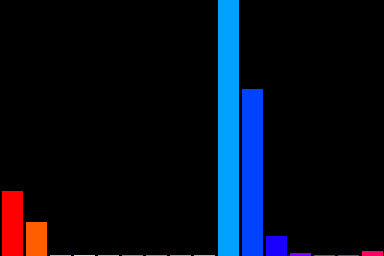

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


KeyboardInterrupt: ignored

In [0]:

def show_hist(hist):
    bin_count = hist.shape[0]
    bin_w = 24
    img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
    for i in xrange(bin_count):
        h = int(hist[i])
        cv.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    cv2_imshow(img)



def camshift_detection():
  selection = []
  track_window = []
  detected = []


  VideoCapture()
  eval_js('create()')
  while True: 
    byte = eval_js('capture()')
    im = byte2image(byte)
    vis = im.copy()
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

    # The first time. this "if" obtains histogram for the first time.
    # If no face was detected, new iteration and take new photo to detect the face.
    if selection == []:
      selection = detect(gray)
      #print(selection*)
      if selection == []:# we must detect a face or else we won't move forward
        continue
      else:
        #print(type(selection))
        x0, y0, x1, y1 = tuple(selection.reshape(1, -1)[0])
        # Select just the face region
        hsv_roi = hsv[y0:y1, x0:x1]
        mask_roi = mask[y0:y1, x0:x1]
        # get distribution only one time of a face
        hist = cv.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
        cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
        hist = hist.reshape(-1)
        #Define track window to the face area
        track_window= (x0,y0, x1-x0, y1-y0)
        show_hist(hist) # We can omit this part

        vis_roi = vis[y0:y1, x0:x1]
        cv.bitwise_not(vis_roi, vis_roi)
        vis[mask==0]=0

    if track_window and track_window[2] > 0 and track_window[3] > 0:
      # We will come here for the next photo after detecting a face
      # Prob will contain the likely areas where the face is (according to histogram)
      prob = cv.calcBackProject([hsv], [0], hist, [0, 180], 1)
      prob &= mask      
      term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
      # Update track window to follow the new face area
      track_box, track_window = cv.CamShift(prob, track_window, term_crit)
      #print(track_box)
      xmin,ymin,dx,dy = track_window  
      detectedArea = [(xmin, ymin, xmin+dx, ymin+dy)]  
      draw_rects(prob, detectedArea, (255,0,0), 'Detected face')
      eval_js('showing("{}")'.format(image2byte(prob)))



    

camshift_detection()



In [0]:
a

1

# Laboratory 3
This laboratory will be based on the camshift software.
Very similarly as in the lab 2, we will use camshift to follow the user's face but instead of marking the face, we will simply remove it by setting an opaque on the face.



The following image outputs the result.

![picture](https://drive.google.com/uc?id=1cSm5Nv4J8EiQgO2RaxxuZ0fLyJ_h1cH1)


In [0]:
# Mehod to merely paint a white rectangle delimited by region on the image img
def draw_rects_filled(img, rects, color, Label):
    cv2.putText(img, Label, (rects[0][0], rects[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, cv2.FILLED)


# The code in this method is practically the same as in lab2.
def camshift_face_removal():
  selection = []
  track_window = []
  detected = []


  VideoCapture()
  eval_js('create()')
  while True: 
    byte = eval_js('capture()')
    im = byte2image(byte)
    vis = im.copy()
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

    # The first time. this "if" obtains histogram for the first time
    if selection == []:
      selection = detect(gray)
      #print(selection*)
      if selection == []:# we must detect a face or else we won't move forward
        continue
      else:
        #print(type(selection))
        x0, y0, x1, y1 = tuple(selection.reshape(1, -1)[0])
        #Select the face
        hsv_roi = hsv[y0:y1, x0:x1]
        mask_roi = mask[y0:y1, x0:x1]
        # get distribution only one time of a face
        hist = cv.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
        cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
        hist = hist.reshape(-1)
        # Update track window for the first time to where the face currently is
        track_window= (x0,y0, x1-x0, y1-y0)
        vis_roi = vis[y0:y1, x0:x1]
        cv.bitwise_not(vis_roi, vis_roi)
        vis[mask==0]=0

    if track_window and track_window[2] > 0 and track_window[3] > 0:
      prob = cv.calcBackProject([hsv], [0], hist, [0, 180], 1)
      prob &= mask
      # prob will contain the pixels where the face is more likely to be
      # we apply a filter using mask
      term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
      #update track window to where the face probably now is
      track_box, track_window = cv.CamShift(prob, track_window, term_crit)
      #print(track_box)
      xmin,ymin,dx,dy = track_window  
      detectedArea = [(xmin, ymin, xmin+dx, ymin+dy)]  
      # Paint the detected face
      draw_rects_filled(prob, detectedArea, (255,0,0), 'Removed face')
      eval_js('showing("{}")'.format(image2byte(prob)))

camshift_face_removal()



# Laboratory 4
This laboratory will be based on the camshift software. In this case, we will set an opaque box on the user's face but, additionally, we will also detect the user's hand. Once the hand is the detected, we will follow it using camshift (as in the previous laboratories). Similarly, once the face is covered on a black box, we will also follow it.

IMPORTANT: The detection of the hand will merely consist of analyzing the whole image and finding the face histogram, hence we assume the face and the hand's histogram are practically the same. There is no machine learning detecting algorithm for the hand. This greatly reduces the accuracy of this algorithm.

![picture](https://drive.google.com/uc?id=191-gy8baG8dbv9IpC283GQLSOa1m9-m3)

Even though it may not look clear, in this face there is a face completely covered by a black box.


![picture](https://drive.google.com/uc?id=1VXY-sFnurCuZ3Vrkml4YpcKdIaKWUcCl)


In this image, you can see the detected hand but stored in the working directory. This is the hand extracted by the algorithm from the whole photo.

In [11]:

#Method to extend (margin) region of a box (area) inside an image (im)
def amplifyArea(im, area, margin):
    new_area = [0,0,0,0]
    new_area[0] = max(area[0]-margin, 0)
    new_area[1] = max(area[1]-2*margin, 0)
    new_area[2] = min(area[2] + 2*margin, im.shape[1])
    new_area[3] = min(area[3] + 2*margin, im.shape[0])
    return new_area

#Mehtod to pain the black box
def draw_rects_filled(img, rects, color, Label):
    cv2.putText(img, Label, (rects[0][0], rects[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, cv2.FILLED)

#Method to store the image in the current working directory
def storeHand(hand):
  cv2.imwrite('image.png', hand)


def camshift_detection():
  selection = []
  track_window = []
  detected = []
  #detectedArea = []
  detectedface = []
  amplified_margin = 50
  hsv_roi_selection = []
  vis_roi_selection = []
  black_box_coordinates = []
  track_window_hand = []
  face_size = []
  first_time = True

  VideoCapture()
  eval_js('create()')
  while True: 
    first_time = False
    #pdb.set_trace()
    byte = eval_js('capture()')
    im = byte2image(byte)
    vis = im.copy()
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    # Mask is configured to do a more "aggresive" filter to the hsv. 
    # Both for the face and the complete image
    mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
    # Detect a face
    if selection == [] :
      # Detect face
      selection = detect(gray)
      if selection == [] : 
        # Don't do anyhting until face detected
        continue
      else:
        # Face detected
        #pdb.set_trace()
        first_time = True
        selection = selection[0]
        # Coordinates of face
        x0,y0,x1,y1 = tuple(selection)
        face_size = (x0, y0, x1-x0, y1-y0)
        # Get face distribution (histogram). Crop image to get just the face
        hsv_roi = hsv[y0:y1, x0:x1]
        mask_roi = mask[y0:y1, x0:x1]
        hist = cv.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
        cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
        hist = hist.reshape(-1)
        # Set black box area in face
        drawing_area = (x0, y0, x1, y1)
        #pdb.set_trace()
        # Track window face is where we will search for the NEXT face position          
        track_window_face = (x0,y0, x1-x0, y1-y0)
        prob_face = cv.calcBackProject([hsv], [0], hist, [0, 180], 1)
        prob_face &= mask
        term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
        track_box_face, track_window_face = cv.CamShift(prob_face, track_window_face, term_crit)
        xmin,ymin,dx,dy = track_window_face
        black_box_coordinates = (xmin, ymin, xmin+dx, ymin+dy)
        rects = amplifyArea(hsv, black_box_coordinates, 30)
        draw_rects_filled(hsv, [rects], (0, 0, 0), 'Black box')
        #pdb.set_trace()

        
    

    if first_time == False:
      #pdb.set_trace()
      
      # Update black box coordinate for next photo
      new_selection = amplifyArea(hsv, black_box_coordinates, 50)
      x0,y0,x1,y1 = tuple(new_selection)
      track_window_face = (x0,y0, x1-x0, y1-y0)
      #pdb.set_trace()
      hsv_face = hsv[y0:y1, x0:x1]
      mask_face = cv2.inRange(hsv_face, np.array((0., 60., 20.)), np.array((180., 180., 150.)))      
      #db.set_trace()
      mask_face = mask[y0:y1, x0:x1]
      prob_face = cv.calcBackProject([hsv], [0], hist, [0, 180], 1)
      prob_face &= mask
      #prob_face = cv.calcBackProject([hsv_face], [0], hist, [0, 180], 1)
      #prob_face &= mask_face
      term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
      track_box_face, track_window_face = cv.CamShift(prob_face, track_window_face, term_crit)
      xmin,ymin,dx,dy = track_window_face
      #pdb.set_trace()
      # Check the box is not too big
      if (track_window_face[2]>face_size[2]+20 or track_window_face[3]>face_size[3]+20):
        selection = []
        #print("start over")
        continue
        # We need to recalculate the face
      black_box_coordinates = (xmin, ymin, xmin+dx, ymin+dy)
      
      draw_rects_filled(hsv, [black_box_coordinates], (0, 0, 0), 'Black box')
      

    # Now we analyze the image (with the face covered) and look for the hand
    
    prob = cv.calcBackProject([hsv], [0], hist, [0, 180], 1)
    prob &= mask
    #Initially we don't know where will the user place the hand
    #Therefore the track _Window_hand will be the whole image (with the face covered)
    if track_window_hand == []:
      track_window_hand = (0,0,vis.shape[0], vis.shape[1])
    else:
      track_window_hand = amplifyArea(vis, track_window_hand, 50)
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
    track_box, track_window_hand = cv.CamShift(prob, track_window_hand, term_crit)
    xmin,ymin,dx,dy = track_window_hand
    detectedArea = (xmin, ymin, xmin+dx, ymin+dy)
    
    #Now we move on to painting the hand using the face's histogram
    #pdb.set_trace()
    draw_rects(prob, [detectedArea], (255,0,0), 'Detected hand')

    #Uncomment following line if you want to store hand
    #storeHand(im[detectedArea[1]:detectedArea[3], detectedArea[0]:detectedArea[2]])
    eval_js('showing("{}")'.format(image2byte(prob)))

    






camshift_detection()



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


KeyboardInterrupt: ignored